# Study Zernike Estimation as a function of exposure time

Author: Bryce Kalmbach

Date: 03-06-2023

Software Versions:

`lsst_distrib`: `w_2023_07`

`ts_wep`: 5.1.0

This notebook will compare the results of WEP Zernike estimation as a function of exposure time.

## Additional required packages to run pipeline

This notebook requires the following packages to be installed and set up in your environment if you wish to run the pipeline tasks yourself. If you are just interested in analyzing the output this install is not necessary.

* `ts_wep`: Wavefront Estimation Pipeline [(Github Repo with install instructions)](https://github.com/lsst-ts/ts_wep)

In [1]:
from lsst.daf.butler import Butler
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
repo_dir = '/repo/embargo/'
output_collection = 'u/brycek/DM-38169*'

## Run Zernike estimation (Optional)

If the data has not yet been processed with the WEP pipeline then we can run this section to run the WEP pipeline that runs all the steps to get the Zernikes from the raw data.

This section of the notebook just replicates the same content as found in the notebook [auxTelWepTesting,ipynb](auxTelWepTesting.ipynb).

### Get AuxTel raw data

Get the latest AuxTel data found in `/repo/embargo`

In [3]:
butler = Butler(repo_dir)

Find the exposures.

In [4]:
dataIds = list(butler.registry.queryDataIds(['exposure', 'detector'], collections='LATISS/raw/all', datasets='raw', instrument="LATISS", where='exposure.day_obs IN ( 20230201)'))

From the [night log for 2/2/2023](https://confluence.lsstcorp.org/display/LSSTCOM/2023-02-02+AuxTel+NightLog) we can see that first CWFS run had exposures 434-438. We try to get data from this set of images with 434 and 435.

From the [night log for 2/1/2023](https://confluence.lsstcorp.org/display/LSSTCOM/2023-02-01+AuxTel+NightLog) we can see that first CWFS run had exposures 303-307. We try to get data from this set of images with 303 and 304.

In [11]:
input_collections = ['LATISS/raw/all', 'LATISS/calib/unbounded', 'LATISS/runs/quickLook']
butler = Butler('/repo/embargo/',
                          collections=input_collections)
datasetRefOrType='raw'
year='2023'
monthDay='0202'

exp_short_num_1 = '00434'
data_id_1 = dataId={'instrument':'LATISS', 'detector':0, 'exposure':int(f'{year}{monthDay}{exp_short_num_1}')}
exposure_1 =  butler.get(datasetRefOrType, dataId=data_id_1, )

exp_short_num_2 = '00435' 
data_id_2 = dataId={'instrument':'LATISS', 'detector':0, 'exposure':int(f'{year}{monthDay}{exp_short_num_2}')}
exposure_2 = butler.get(datasetRefOrType, dataId=data_id_2,)

camera = butler.get('camera', {'instrument': 'LATISS'})

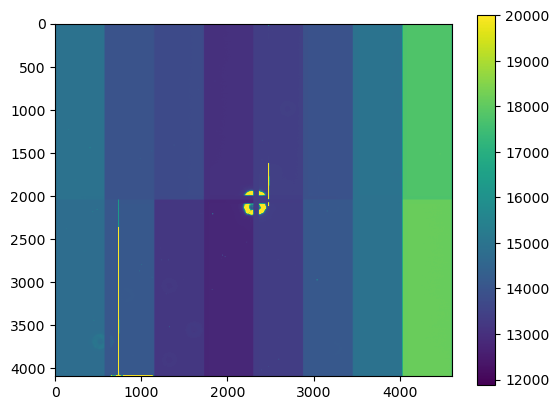

In [12]:
# Take a look at one of the images.
plt.imshow(exposure_1.image.array, vmax=20000)
plt.colorbar()

We have two images but we want to make sure we have a pair of intra-focal and extra-focal. Look at `visitInfo.focusZ` to find this info.

In [7]:
print(exposure_1.visitInfo.focusZ, exposure_2.visitInfo.focusZ)

0.8144523501396179 -0.786647617816925


`exposure_1` has a positive `focusZ` values meaning it is the intra-focal image and `exposure_2` is the extra-focal image so we can use these two images in the WEP pipeline to estimate Zernikes.

### Run WEP pipeline and save output to butler

Here we use **SimplePipelineExecutor** to run in a notebook.

And the pipeline configuration file we used looks like this with inline comments on the different tasks and configurations (it is saved here as `latissWepPipeline.yaml`):

```
# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline used for testing in ts_wep.
description: wep basic processing test pipeline
instrument: lsst.obs.lsst.Latiss
# Use imported instrument configuration
# This import specifies the instrument parameters used in 
# the final two tasks here.
imports:
  - location: $TS_WEP_DIR/policy/cwfs/instData/auxTel/instParamPipeConfig.yaml
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
    config:
      connections.outputExposure: postISRCCD
      # Set the isr configuration we want to use here.
      doApplyGains: false
      doBias: true
      doBrighterFatter: false
      doCrosstalk: false
      doDark: true
      doDefect: true
      doFlat: true
      doFringe: true
      doInterpolate: true
      doLinearize: false
      doNanMasking: true
      doOverscan: true
      doVariance: false
      python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN_PER_ROW'
  generateDonutDirectDetectTask:
    # This is the pipeline task that detects donuts directly from the image
    class: lsst.ts.wep.task.GenerateDonutDirectDetectTask.GenerateDonutDirectDetectTask
    config:
      # connections.exposure: ic_exp
      # Obscuration (inner_radius / outer_radius of primary mirror)
      instObscuration: 0.3525
      # Focal length in m
      instFocalLength: 21.6
      # Aperture diameter in m
      instApertureDiameter: 1.2
      # Move the M2 to fake the move of focal plane dz
      # Move the M2 by 0.8 mm = move the focal plane by 32.8 mm  (magnification of 41)
      # Defocal distance offset in mm
      instDefocalOffset: 32.8
      # Camera pixel size in m
      instPixelSize: 10.0e-6
      opticalModel: 'onAxis'
      donutSelector.useCustomMagLimit: True
      # The donut catalog sorts sources by brightness. So if we set this to 1 we will pick only the brightest source.
      donutSelector.sourceLimit: 1
  cutOutDonutsScienceSensorTask:
    # This task creates 'donutStamps' which are postage stamps of the donut sources that we save to the butler.
    class: lsst.ts.wep.task.CutOutDonutsScienceSensorTask.CutOutDonutsScienceSensorTask
    config:
      # And here we specify the configuration settings
      # connections.exposure: ic_exp
      donutTemplateSize: 200
      donutStampSize: 200
      initialCutoutPadding: 40
  calcZernikesTask:
    # This final task calculates the Zernikes from the `donutStamps` collected
    class: lsst.ts.wep.task.CalcZernikesTask.CalcZernikesTask
```

In [10]:
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline

In [15]:
# Set up information for pipeline
exposure_num_1 = data_id_1['exposure']
exposure_num_2 = data_id_2['exposure']
data_query = f"exposure in ({exposure_num_1}, {exposure_num_2})"

In [13]:
# Set up the output collection with your username
output_collection = 'u/brycek/DM-38169'
# Set up butler that can read and write
butlerRW = SimplePipelineExecutor.prep_butler(repo_dir, inputs=input_collections, output=output_collection)
# Load pipeline from file
pipeline = Pipeline.from_uri("latissWepPipeline.yaml")

In [16]:
executor = SimplePipelineExecutor.from_pipeline(pipeline, where=data_query, butler=butlerRW)
quanta = executor.run(True)

### Look at output stored in butler

In [17]:
# Reload butler to get new collection
butler = Butler(repo_dir)

In [18]:
# Since we now have postISR images we need to add a visit id which is the same as the exposure id for auxtel right now
data_id_1['visit'] = data_id_1['exposure']
data_id_2['visit'] = data_id_2['exposure']

In [19]:
# To make things clearer rename these data ids
data_id_intra = data_id_1
data_id_extra = data_id_2

### Load the postISR images and the `donutCatalog`

The `donutCatalog` is what we call the catalog we used to store the donut sources used to estimate the Zernikes in a run of the WEP pipeline. Since our configuration file above specified only picking one source we get the brightest one as the only row in our `donutCatalog`.

In [21]:
postIsrExtra = butler.get('postISRCCD', dataId=data_id_extra, collections=output_collection)
postIsrIntra = butler.get('postISRCCD', dataId=data_id_intra, collections=output_collection)

In [22]:
donutCatExtra = butler.get('donutCatalog', dataId=data_id_extra, collections=output_collection)
donutCatIntra = butler.get('donutCatalog', dataId=data_id_intra, collections=output_collection)

In [23]:
donutCatExtra

,coord_ra,coord_dec,centroid_x,centroid_y,detector,source_flux,blend_centroid_x,blend_centroid_y
0,1.582993,-0.935185,2021.592894,2031.898288,RXX_S00,1.005180e+08,[],[]


In [24]:
donutCatIntra

,coord_ra,coord_dec,centroid_x,centroid_y,detector,source_flux,blend_centroid_x,blend_centroid_y
0,1.582995,-0.935184,2022.862459,2037.681497,RXX_S00,1.118707e+08,[],[]


Text(0, 0.5, 'Y Pixels')

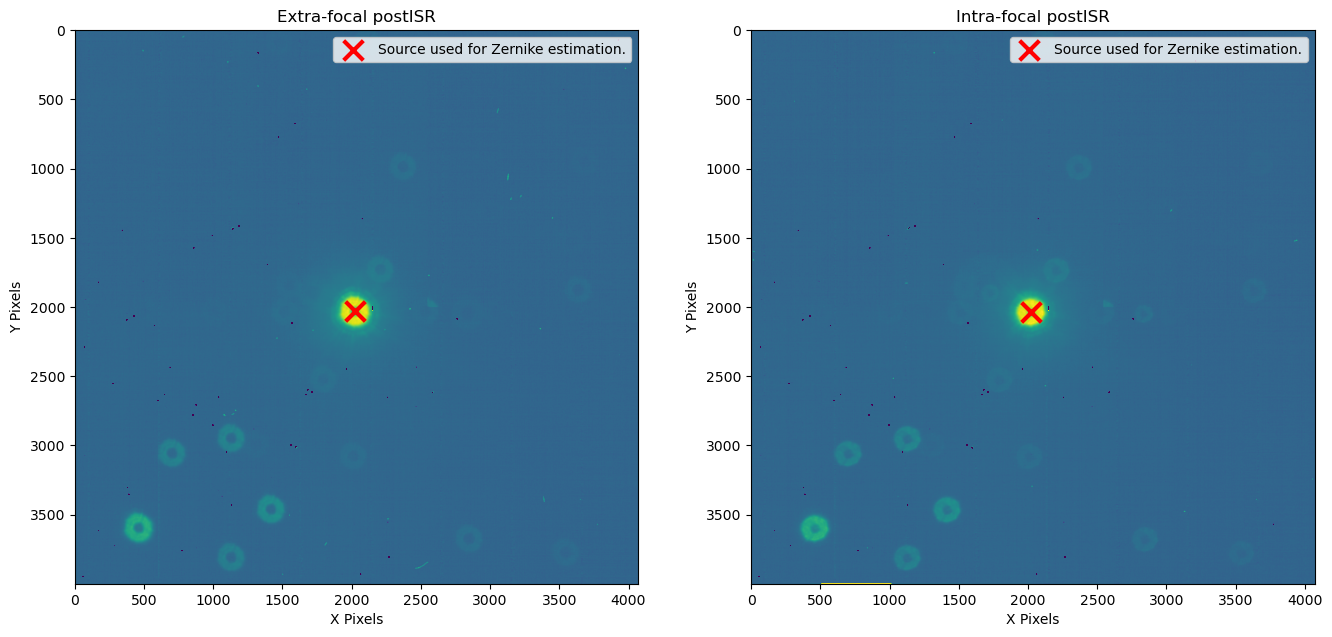

In [25]:
%matplotlib inline

fig=plt.figure(figsize=(16,8))
fig.add_subplot(1,2,1)
plt.imshow(postIsrExtra.image.array, norm=mpl.colors.AsinhNorm(vmin=0, vmax=14000))
plt.title('Extra-focal postISR')
plt.scatter(donutCatExtra['centroid_x'], donutCatExtra['centroid_y'], c='r', marker='x', lw=3, s=200, label="Source used for Zernike estimation.")
plt.legend()
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

fig.add_subplot(1,2,2)
plt.imshow(postIsrIntra.image.array, norm=mpl.colors.AsinhNorm(vmin=0, vmax=14000))
plt.title('Intra-focal postISR')
plt.scatter(donutCatIntra['centroid_x'], donutCatIntra['centroid_y'], c='r', marker='x', lw=3, s=200, label="Source used for Zernike estimation.")
plt.legend()
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

### Load the `donutStamps`

The `donutStamps` are the postage stamp cutouts we take for each donut source and save to the butler. These stamps are then used in the final step to estimate Zernikes. Note that at this step we only use the extra-focal data id for all remaining data products. This allows us to parallelized the processing for each pair of corner wavefront sensors when running on the LSSTCam.

In [28]:
donutStampsExtra = butler.get('donutStampsExtra', dataId=data_id_extra, collections=output_collection)
donutStampsIntra = butler.get('donutStampsIntra', dataId=data_id_extra, collections=output_collection)

Text(0, 0.5, 'Y Pixels')

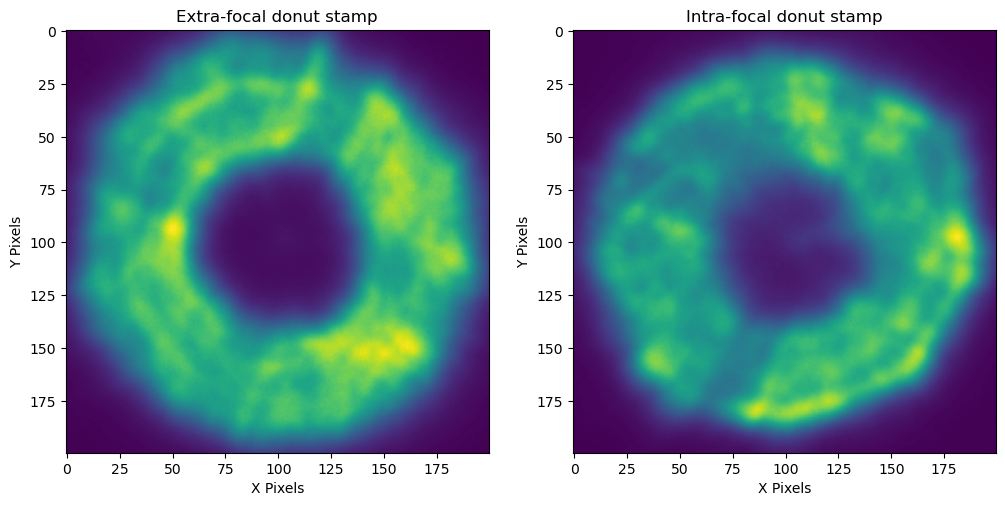

In [29]:
fig=plt.figure(figsize=(12,6))

fig.add_subplot(1,2,1)
plt.imshow(donutStampsExtra[0].stamp_im.image.array)
plt.title('Extra-focal donut stamp')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

fig.add_subplot(1,2,2)
plt.imshow(donutStampsIntra[0].stamp_im.image.array)
plt.title('Intra-focal donut stamp')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

## Load the Zernike output

The final Zernike output of the pipeline comes in two forms. The first is `zernikeEstimateRaw` which has all the Zernikes measured for a CCD that are output in the `donutCatalog` for that CCD. The second is `zernikeEstimateAvg` which is a clipped average of all the Zernikes from a CCD (for more information on the clipping see [this notebook on `calcZernikesTask`](https://github.com/lsst-ts/ts_analysis_notebooks/blob/develop/aos/closed_loop/calcZernikesFromDonutStamps.ipynb).

Since we only have one donut these will be the same and we just load the raw information here.

In [3]:
butler = Butler(repo_dir)

Get collection names and dataIds from butler registry.

In [4]:
output_collections = list(butler.registry.queryCollections('u/brycek/DM-38169/*'))

In [5]:
dataIds0 = list(butler.registry.queryDataIds(['visit', 'detector', 'instrument', 'exposure'], datasets='zernikeEstimateRaw', collections=output_collections[0]))
dataIds1 = list(butler.registry.queryDataIds(['visit', 'detector', 'instrument', 'exposure'], datasets='zernikeEstimateRaw', collections=output_collections[1]))

In [6]:
dataIds0, dataIds1

([{instrument: 'LATISS', detector: 0, exposure: 2023020200435, visit: 2023020200435, ...}],
 [{instrument: 'LATISS', detector: 0, exposure: 2023020100304, visit: 2023020100304, ...}])

We can directly load the visit info for the exposures from the butler without needing to load the exposures.

In [7]:
visitInfo0 = butler.get('postISRCCD.visitInfo', dataId=dataIds0[0], collections=output_collections[0])
visitInfo1 = butler.get('postISRCCD.visitInfo', dataId=dataIds1[0], collections=output_collections[1])

In [8]:
zernOut0 = butler.get('zernikeEstimateRaw', dataId=dataIds0[0], collections=output_collections[0])
zernOut1 = butler.get('zernikeEstimateRaw', dataId=dataIds1[0], collections=output_collections[1])

Finally, plot the output getting the exposure time from the visit info for each exposure.

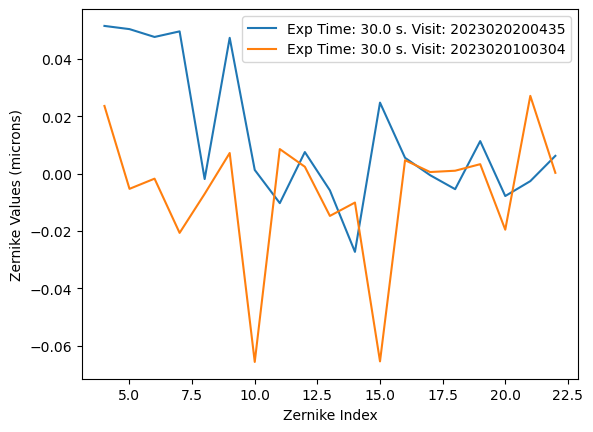

In [9]:
plt.plot(range(4, 23), zernOut0[0], label=f'Exp Time: {visitInfo0.exposureTime} s. Visit: {dataIds0[0]["visit"]}')
plt.plot(range(4, 23), zernOut1[0], label=f'Exp Time: {visitInfo1.exposureTime} s. Visit: {dataIds1[0]["visit"]}')
plt.xlabel('Zernike Index')
plt.ylabel('Zernike Values (microns)')
plt.legend()